In [81]:
import numpy as np
import pandas as pd

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer, PowerTransformer

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns



sk.set_config(display='diagram')

# Functions

# Load Data

In [107]:
df = pd.read_csv('./data/Teams.csv')
df = df[['W','R','H','2B','3B','HR','BB','SO','SB','CS','RA','ER','ERA']]
df = df.select_dtypes(include=np.number)
df = df.dropna()
df.head()

,W,R,H,2B,3B,HR,BB,SO,SB,CS,RA,ER,ERA
0,20,401,426,70,37,3,60.0,19.0,73.0,16.0,303,109,3.55
1,19,302,323,52,21,10,60.0,22.0,69.0,21.0,241,77,2.76
2,10,249,328,35,40,7,26.0,25.0,18.0,8.0,341,116,4.11
3,7,137,178,19,8,2,33.0,9.0,16.0,4.0,243,97,5.17
4,16,302,403,43,21,1,33.0,15.0,46.0,15.0,313,121,3.72


In [108]:
df.isnull().sum() / len(df)

W      0.0
R      0.0
H      0.0
2B     0.0
3B     0.0
HR     0.0
BB     0.0
SO     0.0
SB     0.0
CS     0.0
RA     0.0
ER     0.0
ERA    0.0
dtype: float64

<Axes: >

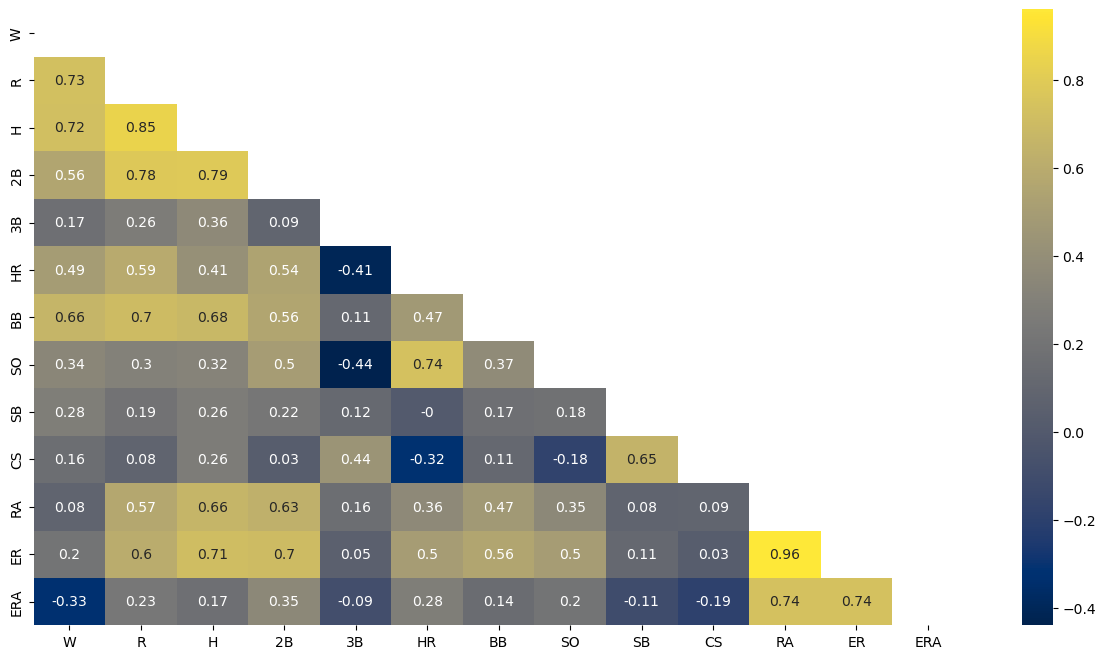

In [138]:
plt.figure(figsize=(15,8))
mask = np.zeros_like(df.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df.corr().round(2), annot=True, mask=mask, cmap="cividis")

# Train Split

In [109]:
#df = df.drop(['TEAM_FIELDING_DP'], axis=1)
#train_df.dropna(inplace=True)
X = df.drop(['W'], axis=1).values
y = df['W']

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21)
print(X_train.shape, y_train.shape)

(1506, 12) (1506,)


# Transform

## impute missing values

imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
X_train_trf = imp_num.fit_transform(X_train)

trf_df = pd.DataFrame(X_train_trf)
trf_df.isnull().sum() / len(trf_df)

X_test_trf = imp_num.transform(X_test)

trf_df = pd.DataFrame(X_test_trf)
trf_df.isnull().sum() / len(trf_df)

## transform data

In [111]:
scaler_sd = StandardScaler()
X_train_sd = scaler_sd.fit_transform(X_train)

In [112]:
scaler_rs = RobustScaler()
X_train_rs = scaler_rs.fit_transform(X_train)

In [113]:
scaler_norm = Normalizer()
X_train_norm = scaler_norm.fit_transform(X_train)

In [114]:
scaler_pwr = PowerTransformer()
X_train_pwr = scaler_pwr.fit_transform(X_train)

In [117]:
x_dict = {"orig":X_train,"sd":X_train_sd,"rs":X_train_rs,"norm":X_train_norm, "pwr":X_train_pwr}

# Model - Lasso - Grid Search

orig ) Best Accuracy Score:  0.9191    Parameters: {} {'alpha': 0.009000000000000001}
sd ) Best Accuracy Score:  0.9191    Parameters: {} {'alpha': 0.003}
rs ) Best Accuracy Score:  0.9191    Parameters: {} {'alpha': 0.002}
norm ) Best Accuracy Score:  0.736    Parameters: {} {'alpha': 0.001}
pwr ) Best Accuracy Score:  0.8671    Parameters: {} {'alpha': 0.003}


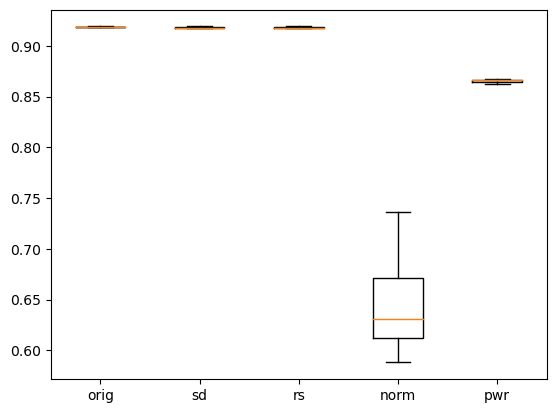

In [118]:
results_lasso = []

lasso = Lasso()
n_splits = 10
n_iter=100
random_state=42


kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

#params = {"alpha" : np.linspace(0.01, 0.1, 100),
#         "tol": np.linspace(0.0001, 0.001, 10)}

params = {"alpha" : np.linspace(0.001, 0.1, 100)}

lasso_cv = RandomizedSearchCV(lasso, params, cv=kf, n_iter=n_iter, random_state=random_state)

# Loop through 
for name, x in x_dict.items():
    lasso_cv.fit(x,y_train)
    cv_results = lasso_cv.cv_results_['mean_test_score']
    results_lasso.append(cv_results)
    
    print(name, ') Best Accuracy Score: ' ,lasso_cv.best_score_.round(4), "   Parameters: {}" , lasso_cv.best_params_)
    
plt.boxplot(results_lasso, labels=x_dict.keys())
plt.show()

Tuned Regression Parameters: {'alpha': 0.009000000000000001}
Tuned Regression Best Accuracy Score: 0.9190825614568455


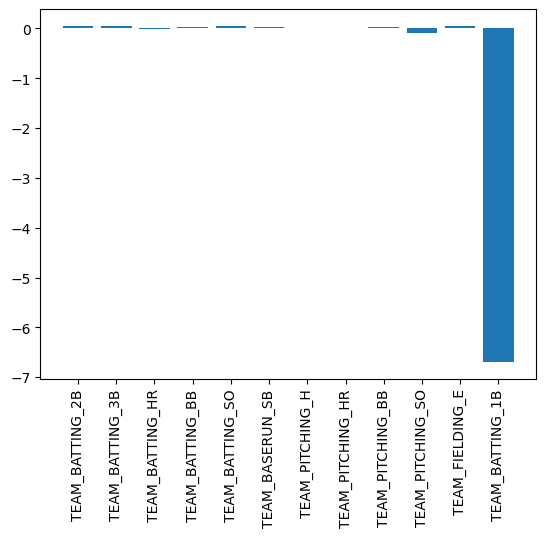

In [119]:
lasso = Lasso()
lasso_cv = RandomizedSearchCV(lasso, params, cv=kf, n_iter=100)
lasso_cv.fit(x_dict['orig'], y_train)

print("Tuned Regression Parameters: {}".format(lasso_cv.best_params_))
print("Tuned Regression Best Accuracy Score: {}".format(lasso_cv.best_score_))

alpha_fit = lasso_cv.best_params_['alpha']
alpha_fit

names = train_df.drop("TARGET_WINS", axis=1).columns
lasso = Lasso(alpha=alpha_fit)
lasso_coef = lasso.fit(x_dict['orig'], y_train).coef_
plt.bar(names, lasso_coef)
plt.xticks(rotation=90)
plt.show()

## Predict

In [124]:
X_test_sd = scaler_sd.transform(X_test)
y_pred_lasso = lasso_cv.predict(X_test_sd)

## Performance

In [125]:
# model evaluation for testing set
mae = mean_absolute_error(y_test, y_pred_lasso)
mse = mean_squared_error(y_test, y_pred_lasso)
r2 = r2_score(y_test, y_pred_lasso)

print("The model performance for testing set")
print("--------------------------------------")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('R2 score is {}'.format(r2))

The model performance for testing set
--------------------------------------
MAE is 43.472971679193314
MSE is 2054.159299942622
R2 score is -6.761189032956886


/var/folders/vm/70vjm63s4j19_zfv4zc5lz480000gn/T/ipykernel_29260/1168805692.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


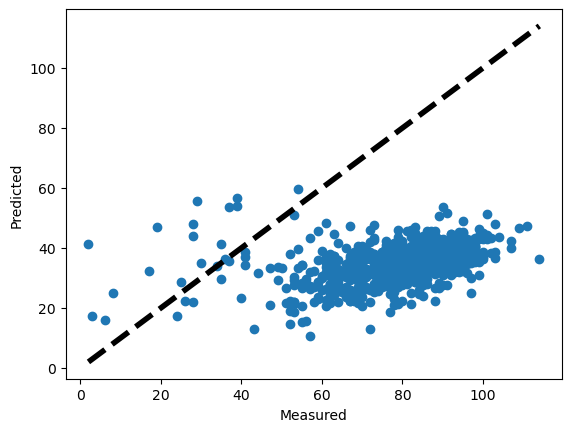

In [131]:
fig,ax = plt.subplots()
ax.scatter(y_test, y_pred_lasso)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
fig.show()

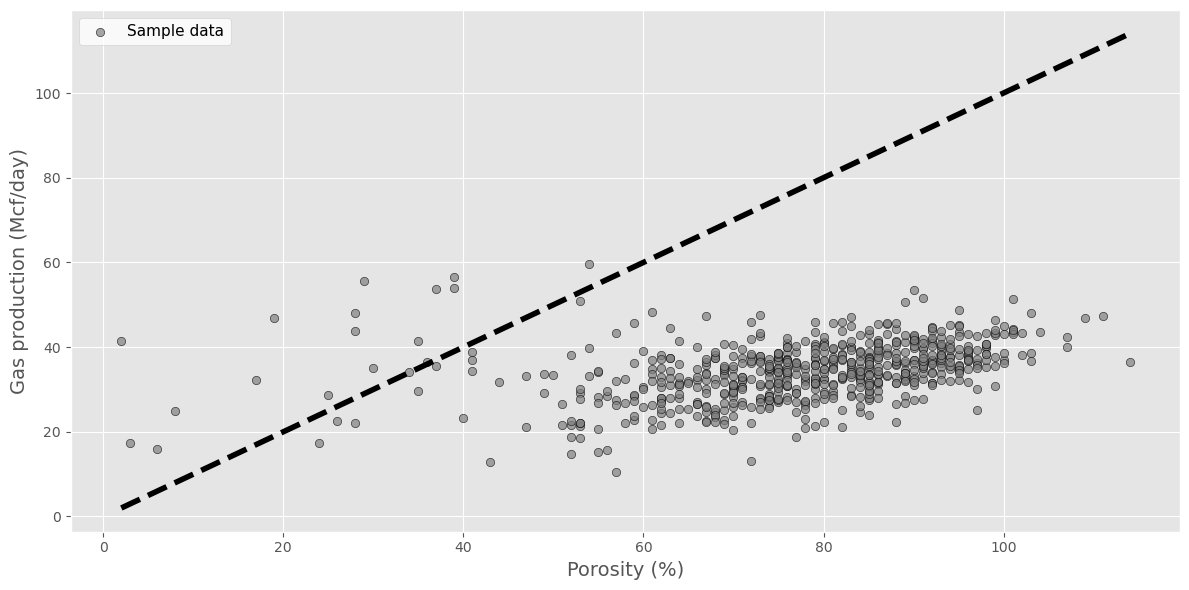

In [150]:
import matplotlib.pyplot as plt

#plt.figure(figsize=(15,8))

plt.style.use('default')
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(12, 6))

#ax.plot(y_test, y_pred_lasso, color='k', label='Regression model')
ax.scatter(y_test, y_pred_lasso, edgecolor='k', facecolor='grey', alpha=0.7, label='Sample data')
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_ylabel('Gas production (Mcf/day)', fontsize=14)
ax.set_xlabel('Porosity (%)', fontsize=14)
ax.legend(facecolor='white', fontsize=11)
#ax.text(0.55, 0.15, '$y = %.2f x_1 - %.2f $' % (model.coef_[0], abs(model.intercept_)), fontsize=17, transform=ax.transAxes)

fig.tight_layout()

<Axes: xlabel='W'>

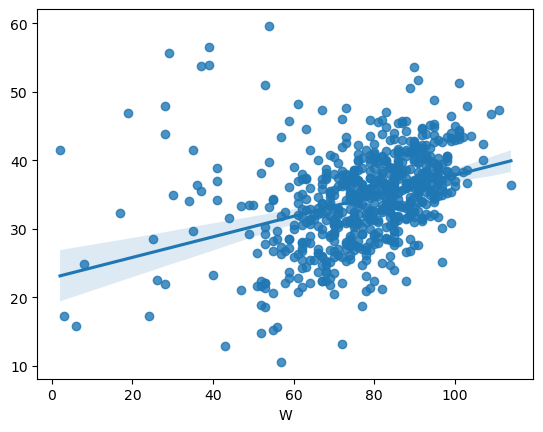

In [139]:
sns.regplot(x=y_test, y=y_pred_lasso)

In [132]:
# Plot the actual vs predicted results
sns.lmplot(x=y_test, y=y_pred_lasso, fit_reg=False)
# Plot the diagonal line
d_line= np.arange(y_test.min().min(), y_test.max().max())
#plt.plot(d_line, d_line, color='red', linestyle='--')
plt.show()

TypeError: Missing required keyword argument `data`.

In [127]:
import statsmodels.api as sm
import statsmodels.formula.api as smf 

In [130]:
lasso_cv

RandomizedSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=Lasso(), n_iter=100,
                   param_distributions={'alpha': array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
       0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018,
       0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027,
       0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035, 0.036,
       0....0.042, 0.043, 0.044, 0.045,
       0.046, 0.047, 0.048, 0.049, 0.05 , 0.051, 0.052, 0.053, 0.054,
       0.055, 0.056, 0.057, 0.058, 0.059, 0.06 , 0.061, 0.062, 0.063,
       0.064, 0.065, 0.066, 0.067, 0.068, 0.069, 0.07 , 0.071, 0.072,
       0.073, 0.074, 0.075, 0.076, 0.077, 0.078, 0.079, 0.08 , 0.081,
       0.082, 0.083, 0.084, 0.085, 0.086, 0.087, 0.088, 0.089, 0.09 ,
       0.091, 0.092, 0.093, 0.094, 0.095, 0.096, 0.097, 0.098, 0.099,
       0.1  ])})